01/03/2024 - This notebook is to port Paco's new 3 Gpc/h Quijote HR simulations into ltu-cmass.

In [4]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from os.path import join
import Pk_library as PKL
import h5py
mpl.rcParams['figure.dpi'] = 300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'

## Load and convert

In [6]:
from colossus.halo import mass_so
from colossus.cosmology import cosmology
from cmass.utils import cosmo_to_astropy

cosmo = [0.3175, 0.049, 0.6711, 0.9624, 0.834]
astropy_cosmo = cosmo_to_astropy(
    cosmo  # fiducial Quijote cosmology
)

colossus_cosmo = cosmology.fromAstropy(
    astropy_cosmo, sigma8=cosmo[4], ns=cosmo[3], cosmo_name='my_cosmo')

In [24]:
datadir = '/anvil/projects/x-phy240043/3Gpc/fiducial_cosmo'
snapz = {0: 0.4, 1: 0.5, 2: 0.6}

snapnum = 2
z = snapz[snapnum]
a = 1/(1+z)
mass_type = 'rockstar_200c'
snapfile = join(datadir, f'out_{snapnum}_pid.list')
rockstar = np.loadtxt(snapfile)
with open(snapfile, 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
hpos = rockstar[:, header.index('X'):header.index('Z')+1]
hvel = rockstar[:, header.index('VX'):header.index('VZ')+1]
hrs = rockstar[:, header.index('Rs')]
if mass_type == 'rockstar_vir':
    hmass = rockstar[:, header.index('Mvir')]  # Halo masses in Msun/h
    hr = rockstar[:, header.index('Rvir')]
elif mass_type == 'rockstar_200c':
    hmass = rockstar[:, header.index('M200c')]  # halo masses in Msun/h
    hr = mass_so.M_to_R(hmass, z, '200c')  # halo physical radius in kpc/h
    hr /= a  # convert to comoving radius

hmass = np.log10(hmass)
hconc = hr/hrs

/tmp/ipykernel_2103789/1990185358.py:25: RuntimeWarning: divide by zero encountered in log10
  hmass = np.log10(hmass)


In [25]:
mmin = np.log10(5e12)

m = hmass > mmin
hmass = hmass[m]
hvel = hvel[m]
hpos = hpos[m]
hr = hr[m]
hconc = hconc[m]

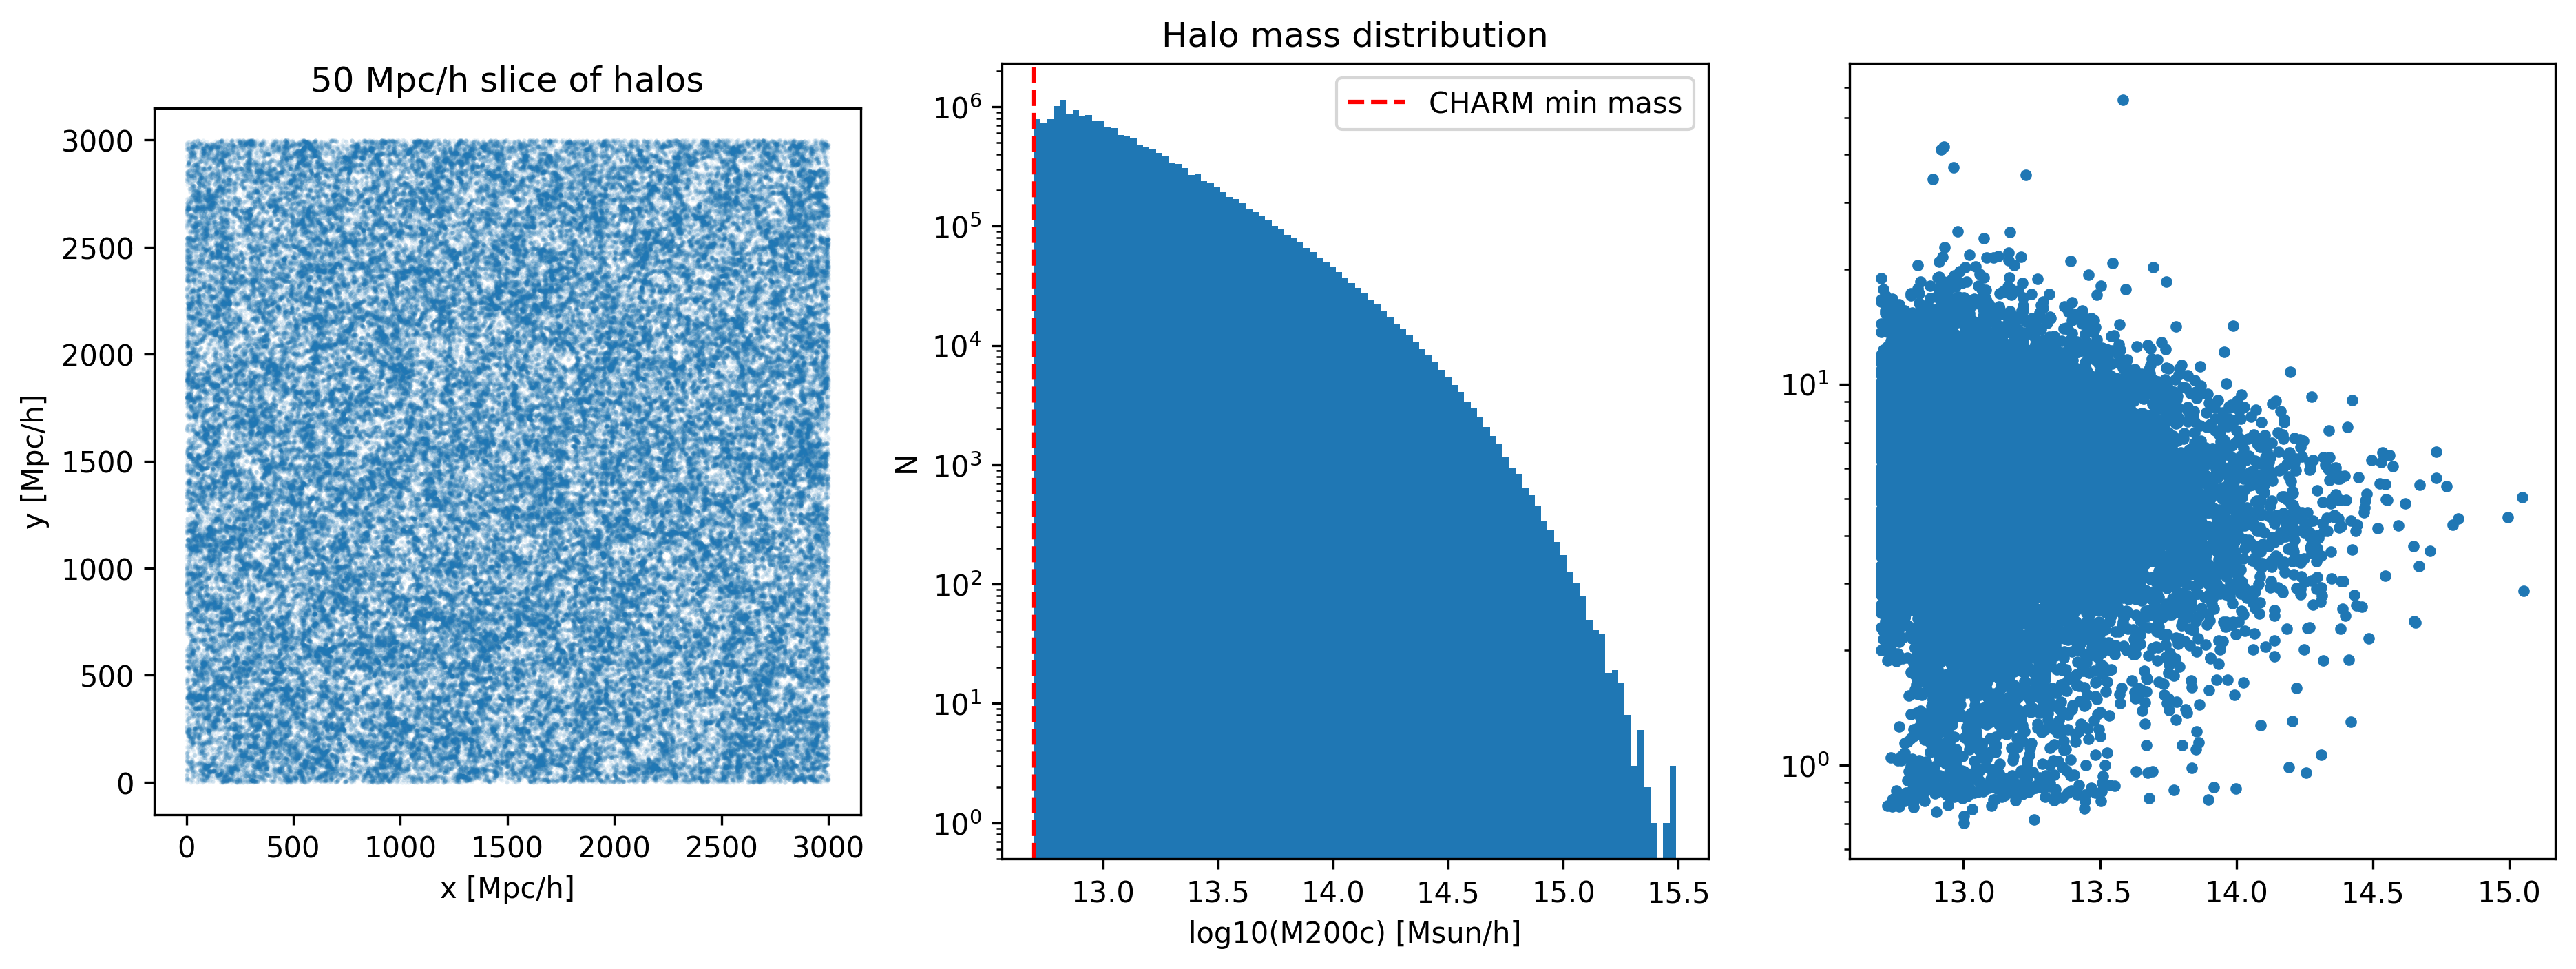

In [26]:
m = hpos[:, 0] < 50
x = hpos[m]
f, axs = plt.subplots(1, 3, figsize=(15, 5))

ax = axs[0]
ax.plot(x[:, 1], x[:, 2], '.', markersize=1, alpha=0.1)
ax.set(xlabel='x [Mpc/h]', ylabel='y [Mpc/h]', title='50 Mpc/h slice of halos')
ax.set_aspect('equal')

ax = axs[1]
ax.hist(hmass, bins=100)
ax.axvline(mmin, color='r', ls='--', label='CHARM min mass')
ax.semilogy()
ax.set(xlabel='log10(M200c) [Msun/h]',
       ylabel='N', title='Halo mass distribution')
ax.legend()

ax = axs[2]
ax.plot(hmass[::1000], hconc[::1000], '.')
ax.semilogy()

In [27]:
from cmass.bias.rho_to_halo import save_snapshot

savepath = '/anvil/scratch/x-mho1/cmass-ili/quijote3gpch/nbody/L3000-N384/0'
z = snapz[snapnum]
a = 1/(1+z)
meta = {'concentration': hconc}

print(f'Saving to {savepath} at a={a:.06f}')
save_snapshot(savepath, a, hpos, hvel, hmass, **meta)

Saving to /anvil/scratch/x-mho1/cmass-ili/quijote3gpch/nbody/L3000-N384/0 at a=0.625000


## Compare to 'fiducial' ltu-cmass sim

In [ ]:
def load_lightcone(fname):
    with h5py.File(fname, 'r') as f:
        ra = f['ra'][...]
        dec = f['dec'][...]
        z = f['z'][...]
    return np.stack([ra, dec, z], axis=1)


qfile = '/anvil/scratch/x-mho1/cmass-ili/quijote3gpch/nbody/L3000-N384/2000/ngc_lightcone/hod20002_aug00000.h5'
qrdz = load_lightcone(qfile)
lfile = '/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/L3000-N384/663/ngc_lightcone/hod06634_aug00000.h5'
lrdz = load_lightcone(lfile)

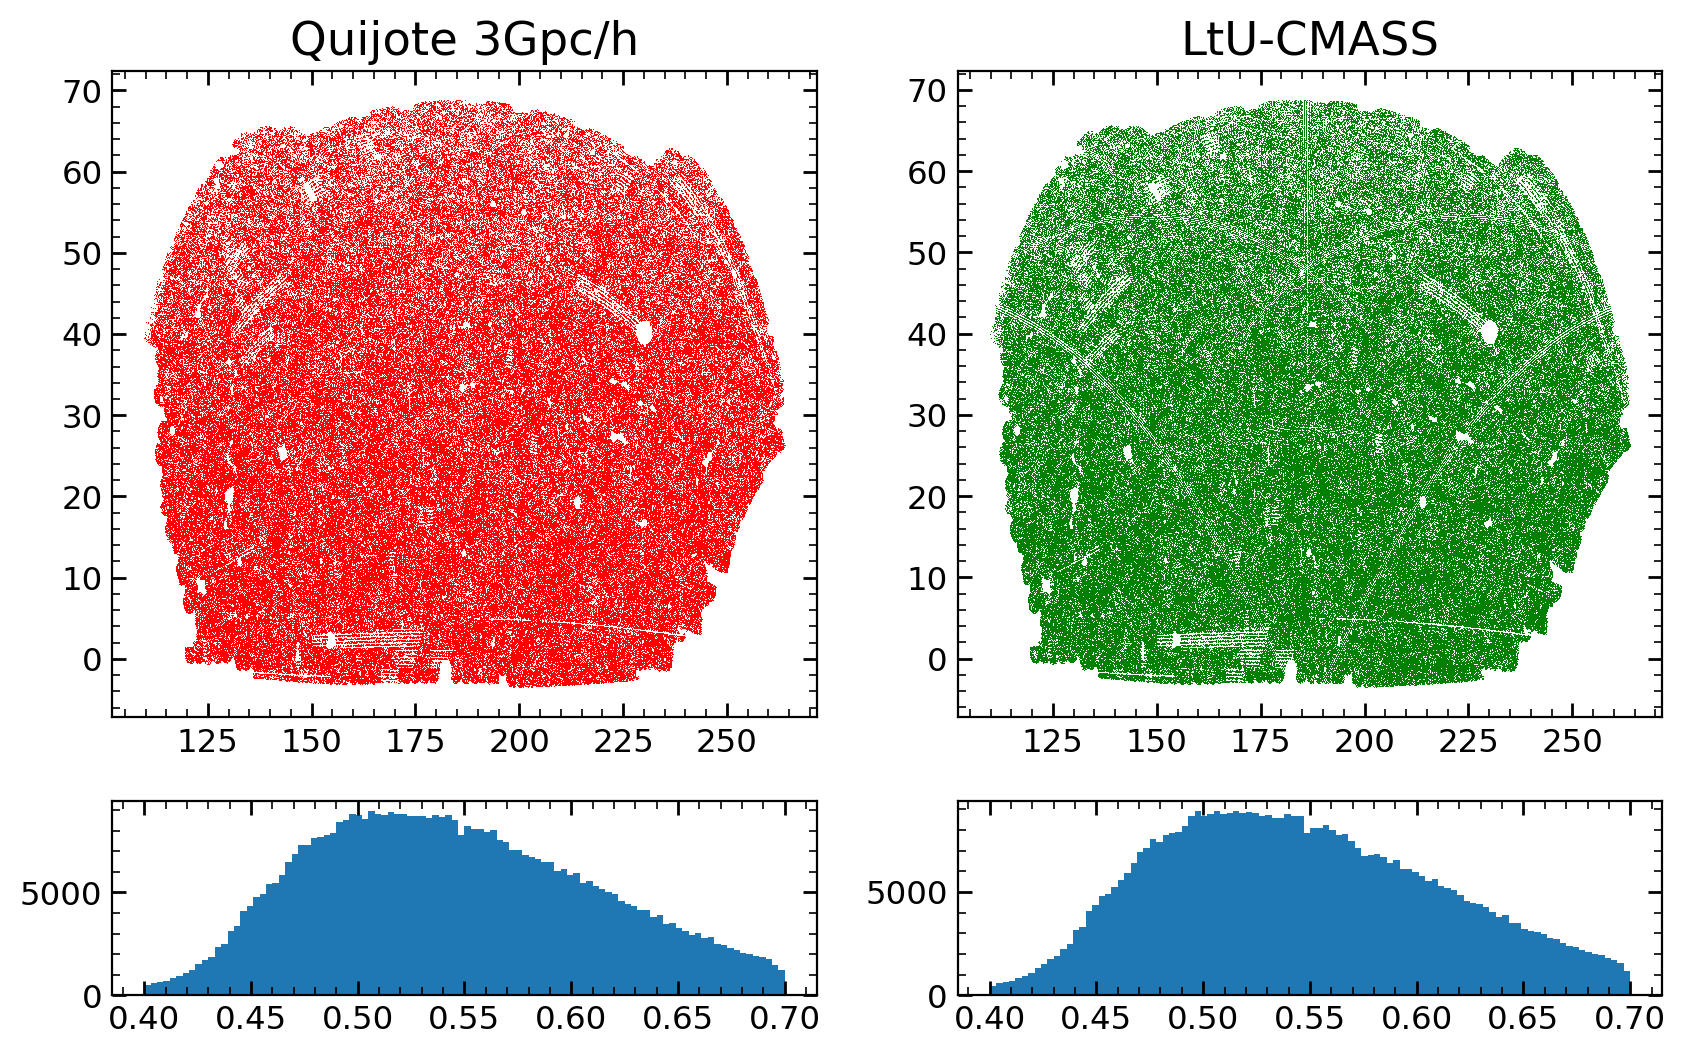

In [ ]:
f, axs = plt.subplots(2, 2, gridspec_kw=dict(height_ratios=[1, 0.3]))
ax = axs[0, 0]
ax.plot(qrdz[:, 0], qrdz[:, 1], 'r,')
ax.set(title='Quijote 3Gpc/h')
ax = axs[1, 0]
ax.hist(qrdz[:, 2], 100)

ax = axs[0, 1]
ax.plot(lrdz[:, 0], lrdz[:, 1], 'g,')
ax.set(title='LtU-CMASS')
ax = axs[1, 1]
ax.hist(lrdz[:, 2], 100)

In [ ]:
from cmass.survey.tools import sky_to_xyz
from astropy.cosmology import Planck18
qpos = sky_to_xyz(qrdz, Planck18)
lpos = sky_to_xyz(lrdz, Planck18)

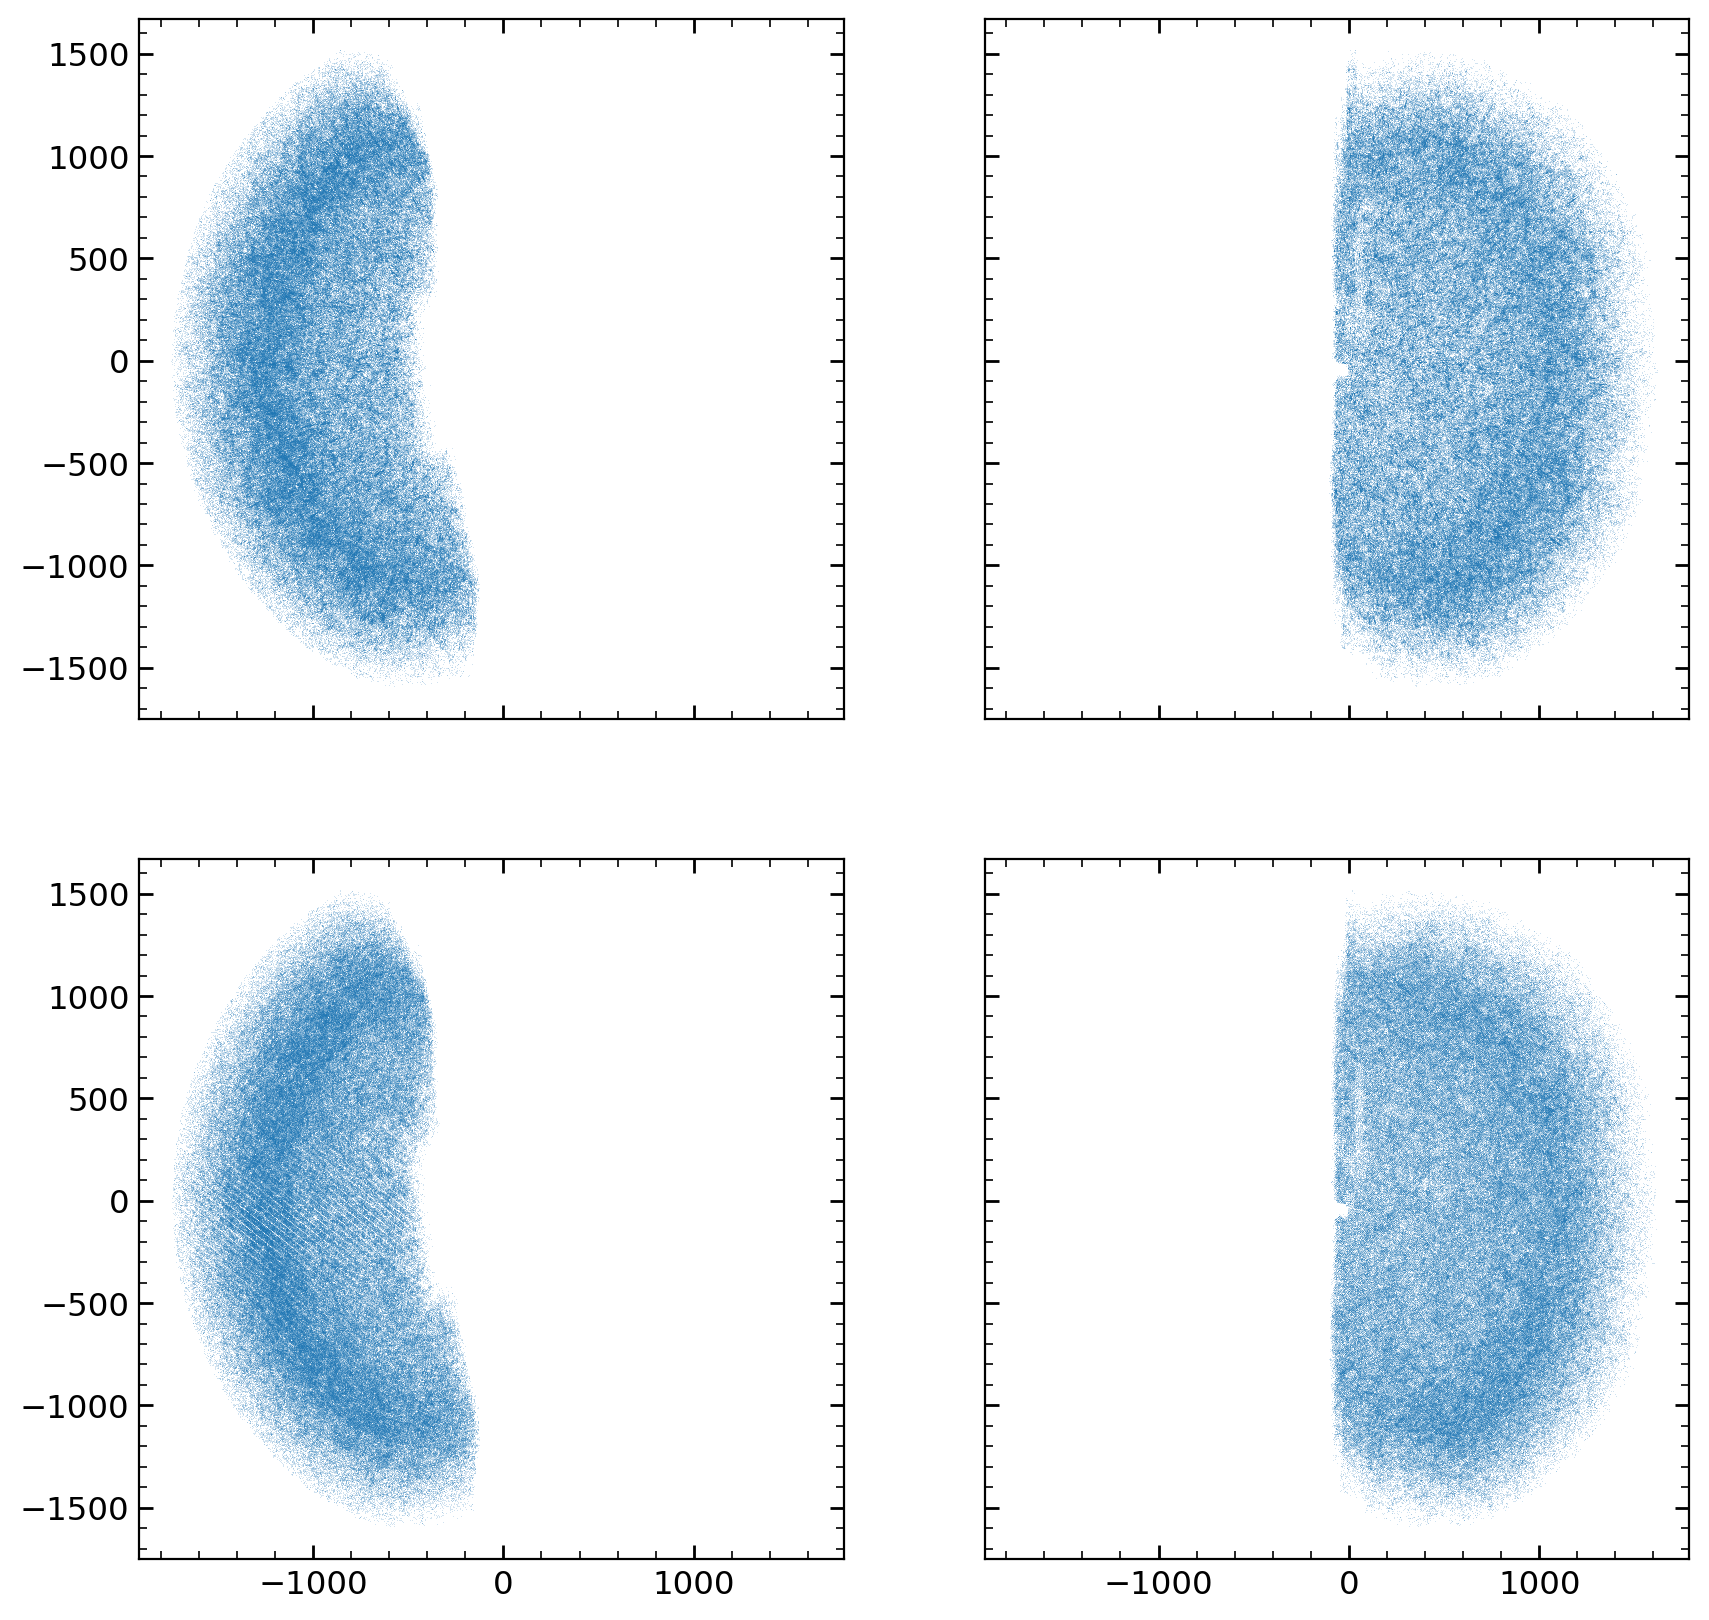

In [ ]:
f, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axs[0, 0]
ax.plot(qpos[:, 0], qpos[:, 1], ',', alpha=0.2)
ax = axs[0, 1]
ax.plot(qpos[:, 2], qpos[:, 1], ',', alpha=0.2)
ax = axs[1, 0]
ax.plot(lpos[:, 0], lpos[:, 1], ',', alpha=0.2)
ax = axs[1, 1]
ax.plot(lpos[:, 2], lpos[:, 1], ',', alpha=0.2)

In [ ]:
# Noise out positions (we do not probe less than Lnoise)
Lnoise = (1000/128)/np.sqrt(3)  # Set by CHARM resolution
qpos += np.random.randn(*qpos.shape) * Lnoise
lpos += np.random.randn(*lpos.shape) * Lnoise

In [ ]:
qpos += [2000, 1800, 250]
lpos += [2000, 1800, 250]
L = 3500

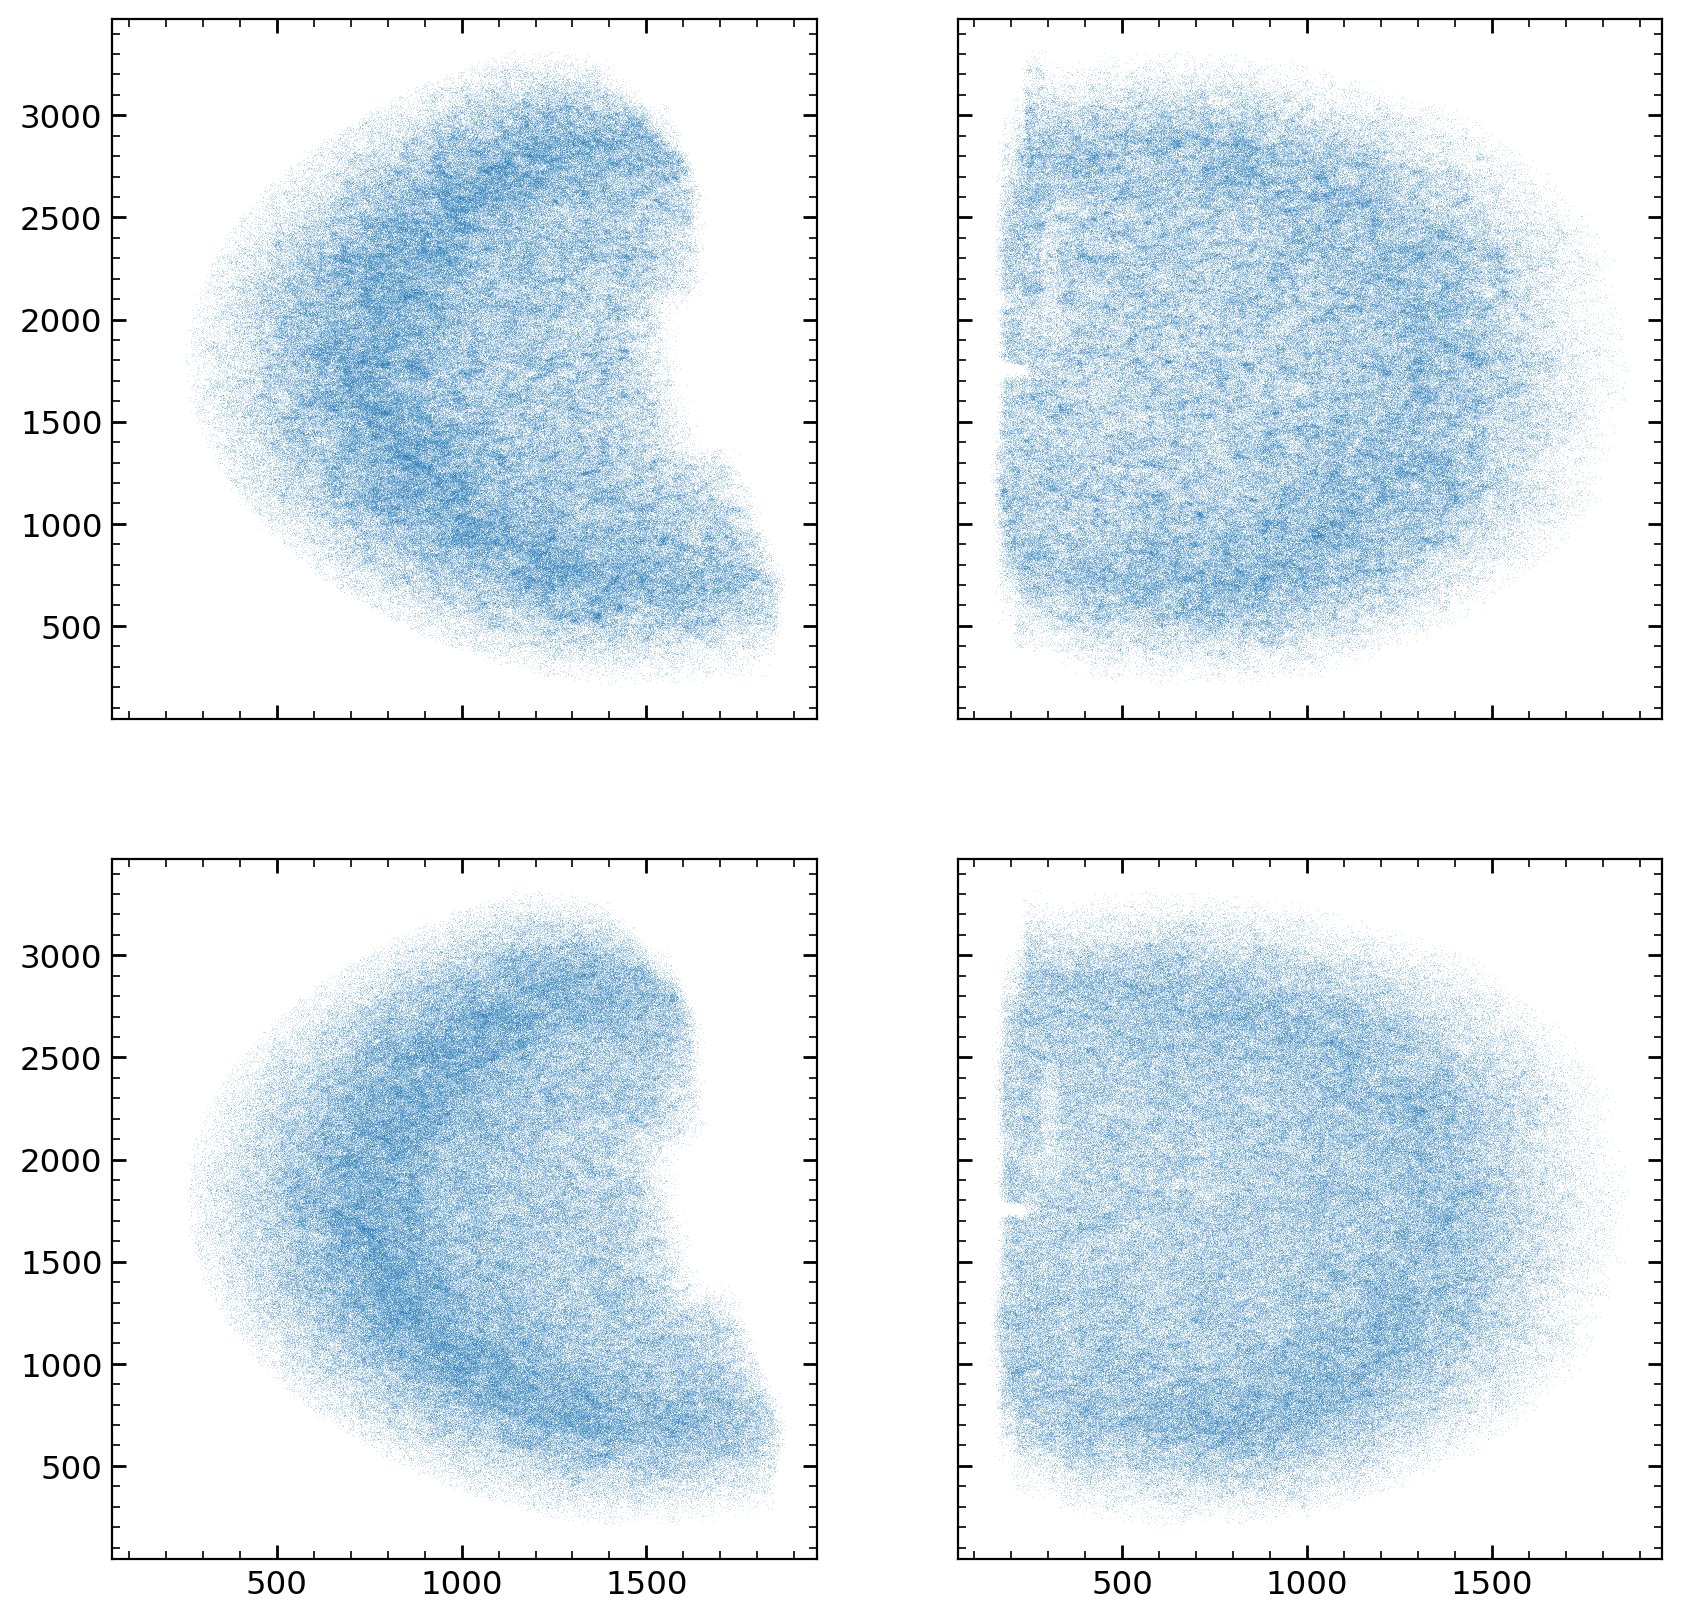

In [ ]:
f, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axs[0, 0]
ax.plot(qpos[:, 0], qpos[:, 1], ',', alpha=0.2)
ax = axs[0, 1]
ax.plot(qpos[:, 2], qpos[:, 1], ',', alpha=0.2)
ax = axs[1, 0]
ax.plot(lpos[:, 0], lpos[:, 1], ',', alpha=0.2)
ax = axs[1, 1]
ax.plot(lpos[:, 2], lpos[:, 1], ',', alpha=0.2)

In [ ]:
N = int(L/1000*128)
qpos = qpos.astype(np.float32)
lpos = lpos.astype(np.float32)

In [ ]:
from cmass.diagnostics.tools import MA
MAS = 'NGP'
qfield = MA(qpos, L, N, MAS=MAS)
lfield = MA(lpos, L, N, MAS=MAS)

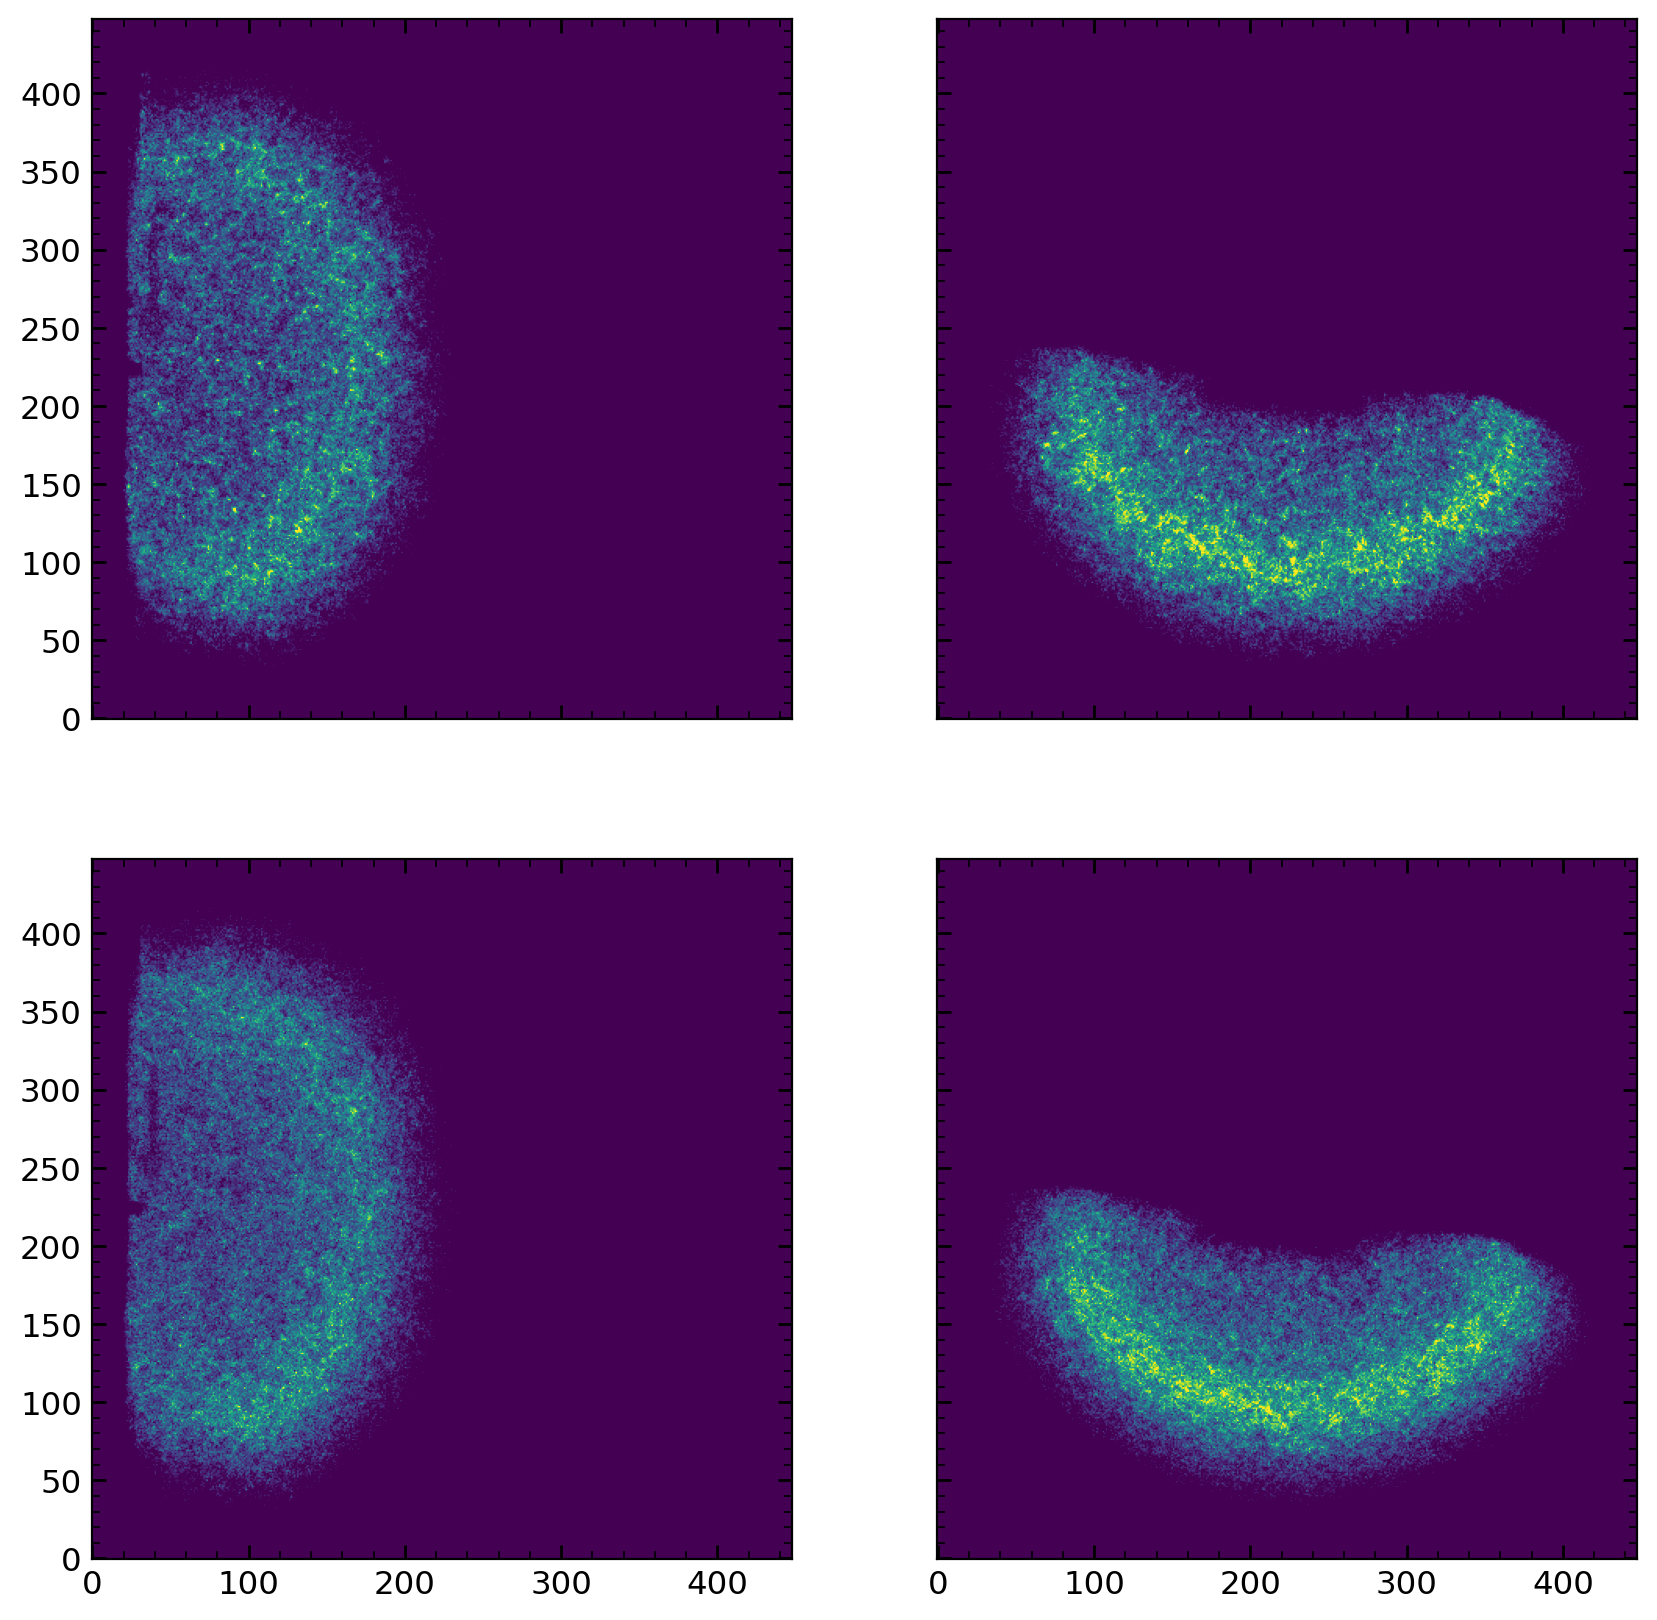

In [ ]:
f, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axs[0, 0]
ax.imshow(np.mean(qfield, axis=0), vmin=-0.2, vmax=10)
ax = axs[0, 1]
ax.imshow(np.mean(qfield, axis=2), vmin=-0.2, vmax=10)
ax = axs[1, 0]
ax.imshow(np.mean(lfield, axis=0), vmin=-0.2, vmax=10)
ax = axs[1, 1]
ax.imshow(np.mean(lfield, axis=2), vmin=-0.2, vmax=10)

In [ ]:
from cmass.diagnostics.tools import calcPk
qk, qPk = calcPk(qfield, L, axis=0,
                 MAS=MAS, threads=1)
lk, lPk = calcPk(lfield, L, axis=0,
                 MAS=MAS, threads=1)

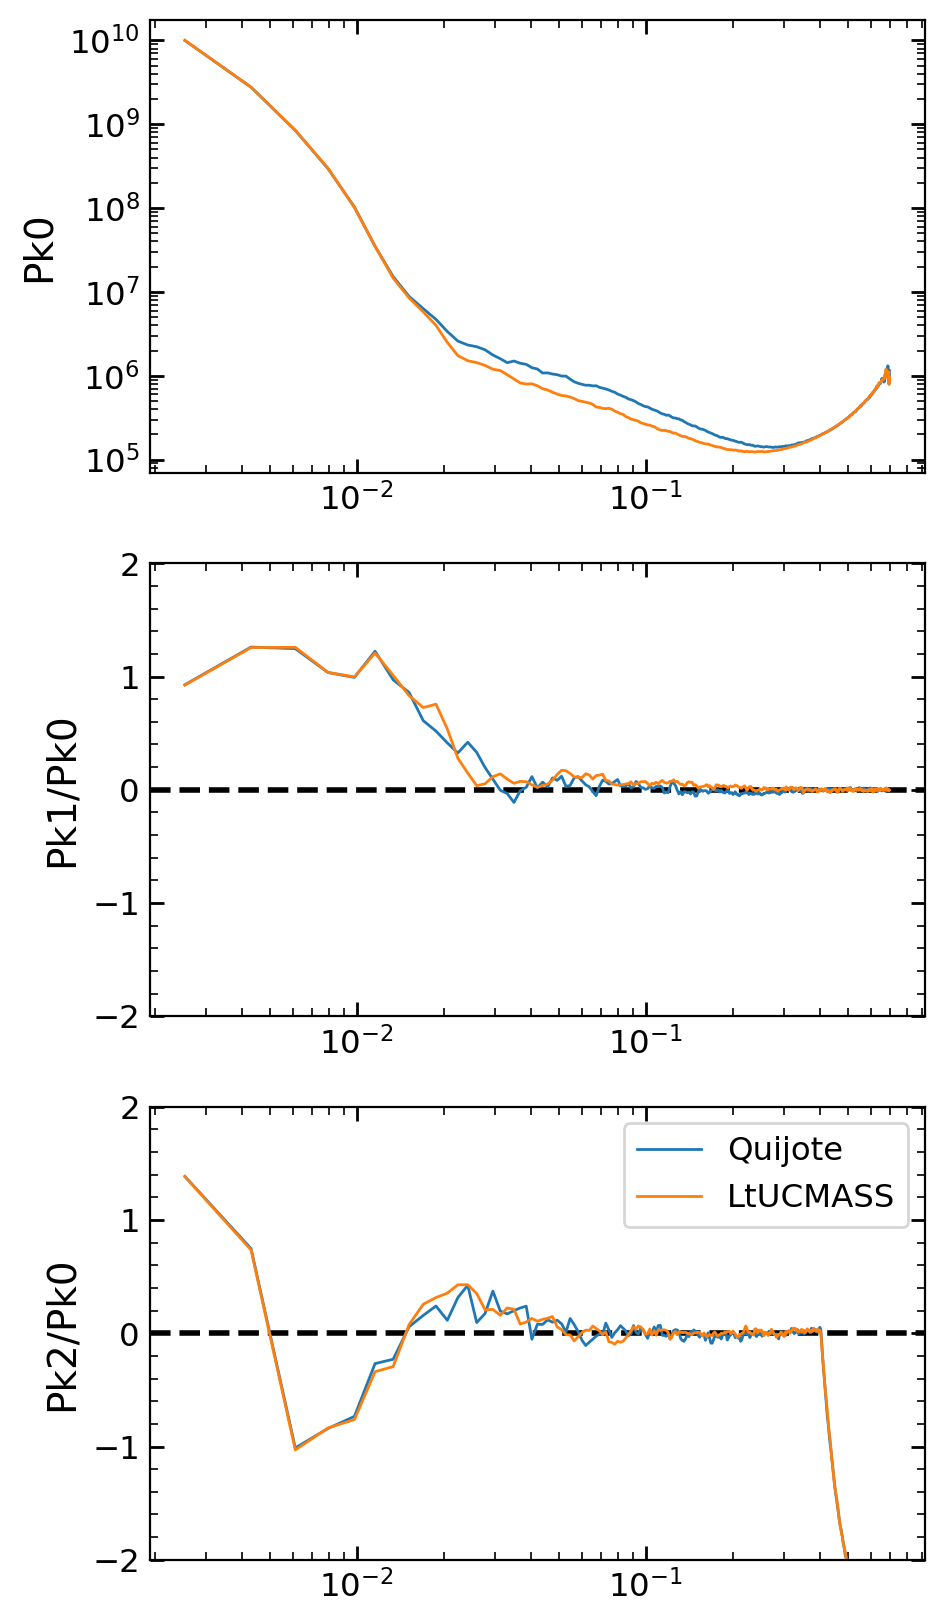

In [ ]:
f, axs = plt.subplots(3, 1, figsize=(5, 10))
for i in range(3):
    ax = axs[i]
    # ax.semilogy()
    if i == 0:
        ax.loglog()
        ax.plot(qk, qPk[:, i], label='Quijote', lw=1)
        ax.plot(lk, lPk[:, i], label='LtUCMASS', lw=1)
        ax.set_ylabel(f'Pk{i}')
    else:
        ax.semilogx()
        ax.axhline(0, ls='--', c='k')
        ax.plot(qk, qPk[:, i]/qPk[:, 0], label='Quijote', lw=1)
        ax.plot(lk, lPk[:, i]/qPk[:, 0], label='LtUCMASS', lw=1)
        ax.set_ylabel(f'Pk{i}/Pk0')
        ax.set_ylim(-2, 2)
ax.legend()

In [ ]:
# check halo velocities
def load_lightcone(fname):
    with h5py.File(fname, 'r') as f:
        ra = f['ra'][...]
        dec = f['dec'][...]
        z = f['z'][...]
    return np.stack([ra, dec, z], axis=1)


qfile = '/anvil/scratch/x-mho1/cmass-ili/quijote3gpch/nbody/L3000-N384/2000/ngc_lightcone/hod20002_aug00000.h5'
qrdz = load_lightcone(qfile)
lfile = '/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/L3000-N384/663/ngc_lightcone/hod06634_aug00000.h5'
lrdz = load_lightcone(lfile)